In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import * 

In [3]:
path = Path('/home/jupyter/chat-data')

In [4]:
path.ls()

[PosixPath('/home/jupyter/chat-data/chats.csv'),
 PosixPath('/home/jupyter/chat-data/models'),
 PosixPath('/home/jupyter/chat-data/human-chat.json'),
 PosixPath('/home/jupyter/chat-data/data_tolokers.json'),
 PosixPath('/home/jupyter/chat-data/data_lm_export.pkl'),
 PosixPath('/home/jupyter/chat-data/rasa-intents.json')]

In [5]:
pd.set_option('max_colwidth', -1)

In [8]:
chat = pd.read_json(path/'human-chat.json')

In [9]:
chat.head()

,evaluation_score,id,sender,sender_class,text
0,NaN,1,participant1,Human,"Thats good for you, i'm not very into new tech"
1,NaN,3,participant1,Human,I am go to gym and live on donations
2,NaN,5,participant1,Human,So vegan... i have dogs maybe i should told then that they may eat cheap salads insted of meat
3,NaN,7,participant1,Human,Dogs or vegan in office?
4,NaN,9,participant1,Human,Strange answer


In [10]:
intents = pd.read_json(path/'rasa-intents.json')

In [11]:
intents.head()

,intentName,text
0,ask_faq_tutorials,are there some tutorials i could look at
1,ask_faq_tutorials,do you have tutorials
2,ask_faq_tutorials,i need a tutorial on how to use rasa
3,ask_faq_tutorials,rasa tutorial
4,ask_faq_tutorials,can you show me a tutorial


In [12]:
intents.describe()

,intentName,text
count,1768,1768
unique,49,1710
top,enter_data,How were you made?
freq,241,4


In [14]:
intents.groupby("intentName").count()

,text
intentName,
affirm,53
ask_builder,46
ask_faq_channels,25
ask_faq_community_size,5
ask_faq_languages,26
ask_faq_opensource,24
ask_faq_platform,19
ask_faq_python_version,10
ask_faq_slots,41


In [15]:
intents = intents.rename(index=str, columns={"intentName": "label"})

In [16]:
intents.head()

,label,text
0,ask_faq_tutorials,are there some tutorials i could look at
1,ask_faq_tutorials,do you have tutorials
2,ask_faq_tutorials,i need a tutorial on how to use rasa
3,ask_faq_tutorials,rasa tutorial
4,ask_faq_tutorials,can you show me a tutorial


In [17]:
# just making the column name the same as the intents df so can concatenate them to train the language model.
# will then just use the intents df for the classifier since the chat labels are meaningless
chat = chat.rename(index=str, columns={"sender_class": "label"}).drop(columns=["evaluation_score", "id", "sender"])

In [18]:
chat.head()

,label,text
0,Human,"Thats good for you, i'm not very into new tech"
1,Human,I am go to gym and live on donations
2,Human,So vegan... i have dogs maybe i should told then that they may eat cheap salads insted of meat
3,Human,Dogs or vegan in office?
4,Human,Strange answer


In [19]:
both_dfs = pd.concat([intents, chat], axis=0, join='outer', join_axes=None, ignore_index=True)

In [20]:
both_dfs.head()

,label,text
0,ask_faq_tutorials,are there some tutorials i could look at
1,ask_faq_tutorials,do you have tutorials
2,ask_faq_tutorials,i need a tutorial on how to use rasa
3,ask_faq_tutorials,rasa tutorial
4,ask_faq_tutorials,can you show me a tutorial


In [21]:
both_dfs.tail()

,label,text
20630,Human,I'm asking about you
20631,Human,Don't waste my time
20632,Human,Are you fucking kidding me?
20633,Human,Shut up
20634,Human,Goodbye


In [22]:
both_dfs.describe()

,label,text
count,20635,20635
unique,50,15273
top,Human,Hello
freq,18867,224


In [23]:
chat.describe()

,label,text
count,18867,18867
unique,1,13649
top,Human,Hello
freq,18867,223


In [25]:
# examples of chats for lm plus additional classifier examples
18867 + 1768

20635

In [36]:
# shuffle rows
both_dfs = both_dfs.sample(frac=1).reset_index(drop=True)

In [38]:
both_dfs.head()

,label,text
0,Human,"Hello, bot. How are you?"
1,Human,i gotta go
2,human_handoff,i'd rather speak with a real rasa employee
3,Human,I owned what?
4,Human,i am a musician. What is your favorite music?


In [39]:
both_dfs.to_csv(path/'combined_chats_and_intents_for_lm_training.csv', index=False)

In [42]:
!head -n5 $path/'combined_chats_and_intents_for_lm_training.csv'

label,text
Human,"Hello, bot. How are you?"
Human,i gotta go
human_handoff,i'd rather speak with a real rasa employee
Human,I owned what?


In [44]:
intents.to_csv(path/'intents_for_clas_training.csv', index=False)

In [45]:
!head $path/'intents_for_clas_training.csv'

label,text
ask_faq_tutorials,are there some tutorials i could look at
ask_faq_tutorials,do you have tutorials
ask_faq_tutorials,i need a tutorial on how to use rasa
ask_faq_tutorials,rasa tutorial
ask_faq_tutorials,can you show me a tutorial
ask_faq_tutorials,i would like to follow a tutorial
ask_faq_tutorials,do you have a tutorial i can follow
ask_faq_tutorials,i am looking for a tutorial
ask_faq_tutorials,i want a tutorial on rasa


In [43]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'combined_chats_and_intents_for_lm_training.csv', text_cols='text')

In [46]:
# Classififer model data using just the intents file
data_clas = TextClasDataBunch.from_csv(path, 'intents_for_clas_training.csv',
                                       text_cols='text', label_cols='label', vocab=data_lm.train_ds.vocab, bs=32)

In [47]:
data_lm.save('data_lm_export_7_14.pkl')
data_clas.save('data_clas_export_7_14.pkl')

In [48]:
data_lm = load_data(path, 'data_lm_export_7_14.pkl')
data_clas = load_data(path, 'data_clas_export_7_14.pkl')

In [49]:
data_lm

TextLMDataBunch;

Train: LabelList (16507 items)
x: LMTextList
xxbos i love talking to people,xxbos i 'm a famous twitch streamer .,xxbos xxmaj nothing . xxmaj just xxunk some of the musical instruments i play,xxbos xxmaj movies,xxbos i get that you love cooking very much
y: LMLabelList
,,,,
Path: /home/jupyter/chat-data;

Valid: LabelList (4128 items)
x: LMTextList
xxbos xxmaj it 's fine . i 'm planning for my xxunk to xxmaj europe next month,xxbos hi,xxbos i have collection over 1000 hats,xxbos do you like traveling ?,xxbos xxmaj what do you teach ?
y: LMLabelList
,,,,
Path: /home/jupyter/chat-data;

Test: None

In [53]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '?',
 'you',
 'i',
 'do',
 '.',
 'what',
 'a',
 'are',
 ',',
 'to',
 'is']

In [54]:
data_clas

TextClasDataBunch;

Train: LabelList (1414 items)
x: TextList
xxbos xxunk,xxbos ok,xxbos xxmaj would you tell me what time it is ?,xxbos book a call,xxbos xxmaj ok i want to talk to your sales team immediately
y: CategoryList
enter_data,affirm,ask_time,contact_sales,contact_sales
Path: /home/jupyter/chat-data;

Valid: LabelList (354 items)
x: TextList
xxbos may i receive the newsletter from now on,xxbos need more data for nlu,xxbos how 's life,xxbos what are the channels xxmaj rasa xxup nlu supports,xxbos can you do anything else ?
y: CategoryList
signup_newsletter,nlu_generation_tool_recommendation,ask_howdoing,ask_faq_channels,ask_whatspossible
Path: /home/jupyter/chat-data;

Test: None

In [55]:
data_clas.show_batch()

text,target
xxbos no wait go back i want a dripping ice cream but a xxunk that xxunk it so you can drink the ice cream later,out_of_scope
"xxbos hey , i xxunk you a couple of days ago but did n't get any response , any news ?",out_of_scope
"xxbos xxmaj do you have friends the same age as you , if so , how old are they ?",ask_howold
"xxbos please hurry , i have xxunk in two weeks to deliver the bot it is for very big company",out_of_scope
xxbos i d like to talk to someone who can explain me what i can do with rasa,contact_sales


In [56]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


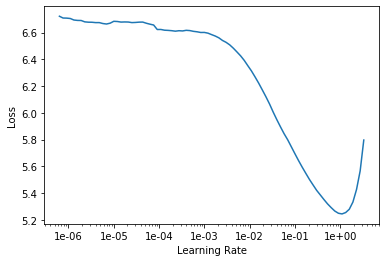

In [58]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.851524,4.490089,0.191008,00:04
1,4.510273,3.149158,0.352073,00:04
2,3.798280,2.973541,0.377041,00:04
3,3.402705,2.910540,0.385746,00:04
4,3.167641,2.886347,0.389700,00:04
5,3.039130,2.884027,0.390306,00:04


In [60]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.847584,2.867271,0.395950,00:04
1,2.812943,2.840988,0.398310,00:04
2,2.776390,2.832798,0.399904,00:04


In [62]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.707835,2.831624,0.398756,00:04
1,2.691604,2.816861,0.406250,00:04
2,2.666176,2.807081,0.405772,00:04


In [63]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.621415,2.808874,0.403954,00:04
1,2.612643,2.806859,0.405134,00:04
2,2.585574,2.802765,0.406696,00:04


In [64]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.539639,2.807441,0.406059,00:04
1,2.543543,2.808489,0.406441,00:04
2,2.520197,2.799353,0.406920,00:04


In [65]:
learn.save('chat-lm-7-12_1')
learn.save_encoder('chat-lm-encoder-7-12_1')

In [66]:
learn.unfreeze()
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.507775,2.790201,0.410714,00:06
1,2.455049,2.770729,0.410459,00:06
2,2.381380,2.755420,0.414923,00:06
3,2.296983,2.760861,0.418941,00:06
4,2.220384,2.777973,0.419165,00:06
5,2.175664,2.775555,0.418973,00:06


In [67]:
learn.save('chat-lm-7-12_2')
learn.save_encoder('chat-lm-encoder-7-12_2')

In [68]:
learn.predict("how are you", n_words=20)

"how are you ? xxbos Yes , i 've been working with mom xxbos Yes xxbos well , Hellow xxbos"

In [69]:
learn.predict("where can", n_words=20)

'where can i build ur voice bot ? xxbos i do nt know xxbos my mother is very traditional while i prefer'

In [70]:
clas_learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
clas_learn.load_encoder('chat-lm-encoder-7-12_2')

In [71]:
clas_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


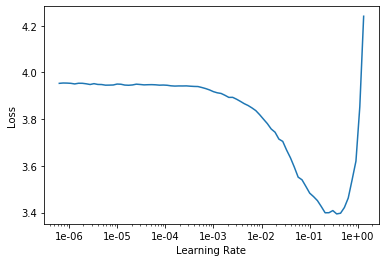

In [72]:
clas_learn.recorder.plot()

In [73]:
clas_learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.671742,3.488455,0.367232,00:00
1,3.079732,1.663184,0.579096,00:00
2,2.434464,1.170082,0.675141,00:00
3,1.993824,1.069264,0.714689,00:00
4,1.666998,1.031837,0.686441,00:00
5,1.456266,1.016706,0.697740,00:00


In [75]:
clas_learn.freeze_to(-2)
clas_learn.fit_one_cycle(6, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.051461,0.959584,0.714689,00:01
1,1.115438,1.002290,0.754237,00:00
2,1.076899,0.943112,0.714689,00:00
3,0.923163,0.837095,0.799435,00:00
4,0.781539,0.760746,0.819209,00:00
5,0.695660,0.758346,0.824859,00:00


In [76]:
clas_learn.unfreeze()
clas_learn.fit_one_cycle(6, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.529212,0.746288,0.824859,00:01
1,0.532206,0.742889,0.822034,00:01
2,0.473082,0.693466,0.838983,00:01
3,0.428789,0.668739,0.850282,00:01
4,0.388615,0.677722,0.847458,00:01
5,0.373038,0.684901,0.844633,00:01


In [77]:
clas_learn.fit_one_cycle(4, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.323678,0.661982,0.841808,00:01
1,0.338898,0.677683,0.841808,00:01
2,0.315683,0.666576,0.841808,00:01
3,0.300666,0.663326,0.838983,00:01


In [78]:
clas_learn.fit_one_cycle(4, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.268173,0.680903,0.838983,00:01
1,0.267530,0.701252,0.827684,00:01
2,0.258296,0.666104,0.844633,00:01
3,0.249950,0.671960,0.847458,00:01


In [79]:
clas_learn.save('chat-clas-7-12_2')

In [83]:
clas_learn.predict("hello!")

(Category greet,
 tensor(37),
 tensor([2.4368e-04, 2.0966e-04, 6.0177e-06, 3.7461e-07, 8.4449e-07, 1.6819e-05,
         8.6414e-05, 1.0969e-05, 2.6912e-05, 2.1723e-07, 4.2425e-05, 4.8506e-08,
         2.1667e-06, 5.2536e-05, 3.3608e-04, 6.8750e-06, 4.2726e-05, 1.8914e-05,
         1.2880e-07, 9.4722e-06, 3.2270e-05, 6.5928e-05, 6.7683e-06, 8.1635e-05,
         2.6070e-05, 2.9731e-07, 6.7896e-05, 3.9577e-06, 3.5674e-05, 2.5830e-05,
         4.5396e-07, 4.5713e-04, 4.8868e-05, 8.3969e-06, 1.0952e-06, 2.0672e-05,
         1.8598e-06, 9.9741e-01, 5.6800e-06, 7.9579e-07, 2.0378e-06, 9.0629e-07,
         1.8804e-07, 8.3015e-05, 4.3609e-06, 1.3790e-06, 2.0322e-06, 1.2727e-06,
         4.8764e-04]))

In [84]:
clas_learn.predict("how are you?")

(Category ask_howdoing,
 tensor(14),
 tensor([8.7458e-05, 1.4071e-05, 2.1662e-06, 1.3923e-05, 3.1480e-06, 1.2515e-06,
         1.0707e-05, 1.9454e-06, 8.6880e-05, 2.5658e-06, 1.1337e-05, 1.1982e-06,
         6.3640e-06, 2.1267e-04, 9.9217e-01, 1.2866e-03, 1.5151e-03, 1.4856e-04,
         3.7184e-06, 1.5312e-05, 2.3536e-05, 6.9239e-05, 4.1695e-05, 7.1865e-05,
         9.4187e-05, 4.1689e-06, 5.8685e-05, 7.3880e-06, 5.0366e-04, 1.3288e-03,
         6.0563e-07, 4.1514e-05, 1.3689e-04, 2.7210e-07, 2.2622e-05, 7.3437e-05,
         1.1523e-05, 3.5031e-04, 7.6551e-05, 1.6140e-05, 6.2998e-06, 5.1706e-07,
         7.0346e-07, 1.3485e-03, 2.9810e-06, 3.2251e-07, 2.6298e-06, 5.0468e-05,
         6.3069e-05]))

In [85]:
clas_learn.predict("what's up")

(Category ask_howdoing,
 tensor(14),
 tensor([2.0465e-04, 3.7014e-06, 2.8888e-06, 2.4329e-05, 4.5654e-05, 2.6721e-06,
         8.8479e-04, 6.2812e-06, 3.3831e-05, 5.7262e-06, 1.9021e-05, 1.1930e-05,
         1.2276e-04, 1.9921e-05, 9.8243e-01, 1.0408e-04, 1.8594e-04, 6.9374e-05,
         5.7868e-06, 3.4688e-06, 3.7237e-05, 3.8332e-04, 2.1138e-05, 3.2467e-04,
         5.0127e-04, 1.6053e-05, 8.8377e-06, 2.5071e-04, 4.9531e-05, 1.1458e-03,
         3.0604e-06, 1.8383e-05, 1.8199e-04, 1.9462e-05, 5.2968e-06, 1.1476e-05,
         3.4525e-05, 1.1727e-02, 1.7382e-04, 1.3444e-04, 3.0107e-06, 4.6011e-06,
         2.5961e-07, 3.9364e-05, 3.4415e-06, 1.8228e-07, 6.9564e-06, 5.6193e-04,
         1.4600e-04]))

In [86]:
from fastai.vision import ClassificationInterpretation

In [87]:
interp = ClassificationInterpretation.from_learner(clas_learn)

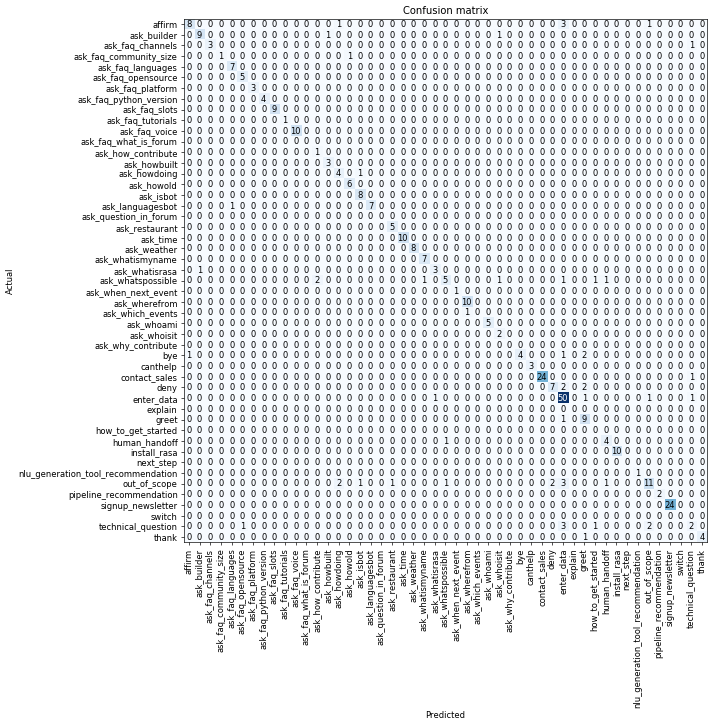

In [88]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [89]:
interp.most_confused()

[('affirm', 'enter_data', 3),
 ('out_of_scope', 'enter_data', 3),
 ('technical_question', 'enter_data', 3),
 ('ask_whatspossible', 'ask_how_contribute', 2),
 ('bye', 'greet', 2),
 ('deny', 'enter_data', 2),
 ('deny', 'greet', 2),
 ('out_of_scope', 'ask_howdoing', 2),
 ('out_of_scope', 'deny', 2),
 ('technical_question', 'out_of_scope', 2),
 ('affirm', 'ask_howdoing', 1),
 ('affirm', 'out_of_scope', 1),
 ('ask_builder', 'ask_howbuilt', 1),
 ('ask_builder', 'ask_whoisit', 1),
 ('ask_faq_channels', 'technical_question', 1),
 ('ask_faq_community_size', 'ask_howold', 1),
 ('ask_howdoing', 'ask_isbot', 1),
 ('ask_languagesbot', 'ask_faq_languages', 1),
 ('ask_whatisrasa', 'ask_builder', 1),
 ('ask_whatspossible', 'ask_whatismyname', 1),
 ('ask_whatspossible', 'ask_whoisit', 1),
 ('ask_whatspossible', 'enter_data', 1),
 ('ask_whatspossible', 'how_to_get_started', 1),
 ('ask_whatspossible', 'human_handoff', 1),
 ('ask_which_events', 'ask_wherefrom', 1),
 ('bye', 'affirm', 1),
 ('bye', 'enter_d